In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
#View column names from measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#View first rows from measurement table
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
#View column names from station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
#View first rows from station table
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

# Precipitation Analysis

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [21]:
# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_data_point)

('2017-08-23',)


In [85]:
# Perform a query to retrieve the data and precipitation scores
last_year_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-24').order_by(Measurement.date).all()

In [86]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(last_year_data)
precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [35]:
# Sort the dataframe by date
sorted_precipitation_df=precipitation_df.sort_values("date", ascending=True)
sorted_precipitation_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


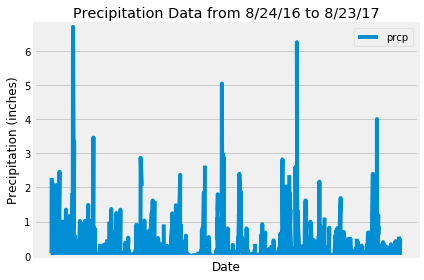

In [57]:
# Use Pandas Plotting with Matplotlib to plot the data
sorted_precipitation_df.plot()
plt.xlabel("Date")
plt.xticks([])
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Data from 8/24/16 to 8/23/17")
plt.legend(["Precipitation"])
plt.ylim(min(sorted_precipitation_df.prcp), max(sorted_precipitation_df.prcp)+0.1)
plt.tight_layout()
plt.show()

In [58]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [66]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Measurement.station).distinct(Measurement.station).count()
print(number_stations)

9


In [77]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).order_by(func.count().desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [79]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperatures_records=session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station=='USC00519281').all()
temperatures_records

[(54.0, 85.0, 71.66378066378067)]

In [84]:
# Choose the station with the highest number of temperature observations.
first_station = session.query(Measurement.station).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
first_station_final=first_station[0]
first_station_final

'USC00519281'

In [92]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_data_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-24', Measurement.station==first_station_final).\
    order_by(Measurement.date).all()
temp_df = pd.DataFrame(last_year_data_temp)
temp_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


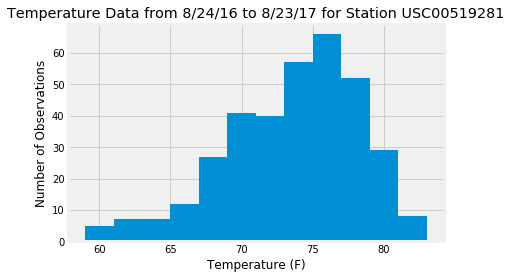

In [95]:
plt.hist(temp_df['tobs'], bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Number of Observations")
plt.title("Temperature Data from 8/24/16 to 8/23/17 for Station " + first_station_final)
plt.show()
